# A Supervised approach to rating predction. 

In this notebook, we feed the LDA and word2vec predictions into a supervised algorithm in order to predict the rating differential.   

First, let's get the rating differential...

In [39]:
import pandas as pd 
from itertools import chain
import cPickle as pickle

In [44]:
reviews = pd.read_pickle('../output/bar_reviews_cleaned_and_tokenized.pickle')

training_users = pickle.load(open('../output/training_users.pickle', 'rb'))
test_users     = pickle.load(open('../output/test_users.pickle', 'rb'))

# Make the active review set training only 
review_train = reviews[reviews.user_id.isin(training_users)]
review_test = reviews[reviews.user_id.isin(test_users)]



# Load the LDA Models

In [49]:
import sys
sys.path.append('../vectorsearch/')
import LDA

# Load the LDA models for businesses and companies
review_lda = LDA.LoadLDAModel('../output/LDA_model_reviews.pickle')
bus_lda = LDA.LoadLDAModel('../output/LDA_model_bus.pickle')


# Vectorize the docs_reviews for use as features

In [277]:
def GenerateInputOutput(review_set, lda_model):
    '''
    Given a list of reviews...
    
    Returns 
        docs_reviews : list
            document string for each review
        bus_ids : list 
            ids for each business
        rev_diff: list 
            difference between the user rating and average rating 
    '''

    # For each business, generate list of average reviews...
    avg_reviews_train = review_set.groupby('business_id').mean()['stars']

    # Get the differential for each review 
    rev_diff = map(lambda (bus_id, stars): stars - avg_reviews[bus_id], 
                   zip(review_set.business_id.values, review_set.stars.values) )
    # Get the review text
    docs_reviews = [" ".join(list(chain.from_iterable(rev))) for rev in review_set.cleaned_tokenized.values]
    # Convert the documents into vectorized form as input to LDA. 
    # *These are the LDA features* 
    doc_LDA_topic_vectors = lda_model.get_doc_topics(docs_reviews)
    
    
    # List of business ids for each review
    bus_ids = review_set.business_id.values
    return doc_LDA_topic_vectors, bus_ids, rev_diff

# Generate for test and training data. 
doc_LDA_topic_vectors_train, bus_ids_train, rev_diff_train = GenerateInputOutput(review_train, review_lda)
doc_LDA_topic_vectors_test, bus_ids_test, rev_diff_test = GenerateInputOutput(review_test, review_lda)


# DOC VECTORS NEED TO BE NORMALIZED ABOVE!!!!!!
# DOC VECTORS NEED TO BE NORMALIZED ABOVE!!!!!!
# DOC VECTORS NEED TO BE NORMALIZED ABOVE!!!!!!

# Get the business topic reviews

In [52]:

# This is business ids corresponding to the business LDA vectors
bus_lda_ids = pickle.load(open('../output/bus_ids_bars_LDA.pickle', 'rb'))

# pd.dataframe('bus_id', 'topic_vector')


# # for each review, lookup the corresponding business topic vector 
# for bus_id in bus_ids_train[:2]:
    

In [97]:
# The topic vector for a given business is given by this dataframe. 
bus_lda_ids = pickle.load(open('../output/bus_ids_bars_LDA.pickle', 'rb'))
bus_vectors = pd.DataFrame()
bus_vectors['business_id'] = bus_lda_ids
transformed = bus_lda.lda.fit_transform(bus_lda.tf)


In [280]:
bus_vectors['topic_vector'] = [bus_topic_vec for bus_topic_vec in transformed]

normed_topic_vecs = map(lambda topic_vec: topic_vec/sqrt(np.dot(topic_vec, topic_vec)),
                        bus_vectors.topic_vector) 
bus_vectors.topic_vector = normed_topic_vecs


In [281]:
bus_vectors.to_pickle('../output/business_LDA_vectors.pickle')
#print bus_vectors.shape

In [282]:
# Find business topic vector each review 
review_bus_vectors_train = pd.DataFrame({'business_id':bus_ids_train})
review_bus_vectors_train = pd.merge(review_bus_vectors_train, bus_vectors, how='left', on='business_id')
# Same for test set. 
review_bus_vectors_test = pd.DataFrame({'business_id':bus_ids_test})
review_bus_vectors_test = pd.merge(review_bus_vectors_test, bus_vectors, how='left', on='business_id')


# Some businesses don't have topic vectors... drop those.  
# Need to also drop them from the relative reviews
blacklist_train = []
for i, rev in enumerate(review_bus_vectors_train.topic_vector.values):
    if np.isnan(rev).any():        
        blacklist_train.append(i)
        
        
blacklist_test = []
for i, rev in enumerate(review_bus_vectors_test.topic_vector.values):
    if np.isnan(rev).any():
        blacklist_test.append(i)
        
        
review_bus_vectors_train['review_diff'] = rev_diff_train
review_bus_vectors_test['review_diff'] = rev_diff_test

review_bus_vectors_train['review_topic_vector'] = [doc for doc in doc_LDA_topic_vectors_train]
review_bus_vectors_test['review_topic_vector'] = [doc for doc in doc_LDA_topic_vectors_test]

# Drop the blacklisted businesses....
review_bus_vectors_train = review_bus_vectors_train.drop(review_bus_vectors_train.index[blacklist_train])
review_bus_vectors_test  = review_bus_vectors_test.drop(review_bus_vectors_test.index[blacklist_test])

       

# Stack the input vectors

In [283]:
X_TRAIN =  np.append(np.vstack(review_bus_vectors_train.review_topic_vector.values),
                     np.vstack(review_bus_vectors_train.topic_vector.values), axis=1)
Y_TRAIN =  review_bus_vectors_train.review_diff.values

X_TEST  =  np.append(np.vstack(review_bus_vectors_test.review_topic_vector.values),
                     np.vstack(review_bus_vectors_test.topic_vector.values), axis=1)
Y_TEST  =  review_bus_vectors_test.review_diff.values


np.save('../output/bar_X_TRAIN.npy', X_TRAIN)
np.save('../output/bar_Y_TRAIN.npy', Y_TRAIN)

np.save('../output/bar_X_TEST.npy', X_TEST)
np.save('../output/bar_Y_TEST.npy', Y_TEST)



print X_TRAIN.shape
print Y_TRAIN.shape

(186727, 40)
(186727,)


# Get all businesses that were reviewed by a user

The objective function we want to optimize is the L2 loss on the difference between the users actual rating minus the average (this is $f$) and the predicted rating differential for the business $J = (f-\hat{f})^2$.   In contrast to preducting the rating directly, this will allow the supervised alogrithm to try and predict deviations from the average behavior.   Hence we can try to find underdogs, or places that may not be rated well, but have a high probability of being liked by the user.  

In [252]:
from sklearn.ensemble import RandomForestRegressor



def RunRFClassifier(n_samples, X, Y, **kwargs):
    RF = RandomForestRegressor(**kwargs)
    RF.fit(X[:n_samples], Y[:n_samples])
    return RF
    


def getRMS_error(RF, X, Y): 
    Y_predict = RF.predict(X)
    MSE = (Y-Y_predict)**2
    RMS_errors = np.sqrt(np.average(MSE))
    return RMS_errors, MSE 


RF_settings = {'n_estimators':500, 
               'max_depth':10, 
                'min_samples_split':2, 
                'min_samples_leaf':5,
                'min_weight_fraction_leaf':0.0,
                'max_features':'auto', 
                'max_leaf_nodes':None,
                'bootstrap':True, 
                'oob_score':True,
                'n_jobs':12,
                'random_state':0}


RF = RunRFClassifier(10000, X_TRAIN, Y_TRAIN, **RF_settings)


RMS_train, MSE_train = getRMS_error(RF, X_TRAIN[:n_samples], Y_TRAIN[:n_samples])
RMS_test, MSE_test = getRMS_error(RF, X_TEST[:n_samples], Y_TEST[:n_samples])
print 'RMS Training Error', RMS_train
print 'RMS Test Error', RMS_test




RMS Training Error 0.737927888614
RMS Test Error 1.12136518249


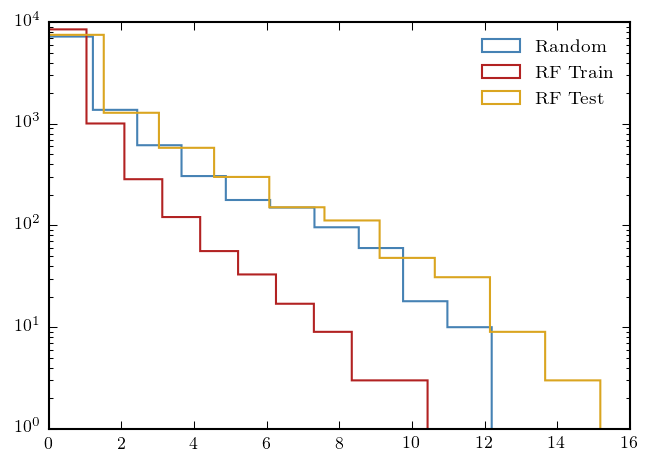

In [265]:
bins = np.linspace(0,4,21)

plt.hist(Y_TRAIN[:n_samples]**2, histtype='step', label='Random')
plt.hist(MSE_train, histtype='step', label='RF Train')
plt.hist(MSE_test, histtype='step', label='RF Test')

plt.yscale('log')
plt.legend(frameon=False)

In [273]:
from sklearn.neural_network import MLPRegressor

MLP = MLPRegressor(hidden_layer_sizes=(50, ), activation='relu', algorithm='adam', alpha=0.0001, batch_size='auto', learning_rate='constant', learning_rate_init=0.001, power_t=0.5, max_iter=200, shuffle=True, random_state=None, tol=0.0001, verbose=False, warm_start=False, momentum=0.9, nesterovs_momentum=True, early_stopping=False, 
                                    validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

ImportError: cannot import name MLPRegressor